<a href="https://colab.research.google.com/github/versusic/My-portfolio/blob/main/3_Spam_email_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 2. install the dataset

In [3]:
spam_not_spam_dataset_url = 'https://raw.githubusercontent.com/parameswaraRao-13/DL_MOdel_for_Spam_Email_Detection/master/spam_or_not_spam.csv'
df = pd.read_csv(spam_not_spam_dataset_url)
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [4]:
df['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


# 3. data preperation

In [6]:
df.dropna(inplace=True)

In [7]:
# changing all words to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [8]:
# Define a regex pattern to match URLs
url_pattern = re.compile(r'https?://\S+')

# Define a function to remove URLs from text
def remove_urls(text):
    return url_pattern.sub('', text)

# remove URLs from text
df['email'] = df['email'].apply(remove_urls)

In [9]:
# remove non-word and non-whitespace words
df['email'] = df['email'].replace(to_replace=r'[^\w\s]', value='', regex=True)

# remove digits
df['email'] = df['email'].replace(to_replace=r'\d', value='', regex=True)

In [10]:
# tokenization
df['email'] = df['email'].apply(word_tokenize)

In [11]:
# remove stop words
stop_words = set(stopwords.words('english'))
df['email'] = df['email'].apply(lambda x: [word for word in x if word not in stop_words])

In [12]:
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# define function to lemmatize tokens
def lemmatize_tokens(tokens):
    # convert POS tag to WordNet format
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # lemmatize tokens
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    # return lemmatized tokens as a list
    return lemmas

# apply lemmatization to the text
df['email'] = df['email'].apply(lemmatize_tokens)

In [13]:
# putting all words together
df['email'] = df['email'].apply(lambda x: ' '.join(x))

In [14]:
df.head()

,email,label
0,date wed number aug number number number numbe...,0
1,martin post tasso papadopoulos greek sculptor ...,0
2,man threatens explosion moscow thursday august...,0
3,klez virus die already prolific virus ever kle...,0
4,add cream spaghetti carbonara effect pasta mak...,0


In [15]:
# converting to vector
max_words = 10000
cv = CountVectorizer(max_features=max_words, stop_words='english')
sparse_matrix = cv.fit_transform(df['email']).toarray()

In [16]:
sparse_matrix.shape

(2999, 10000)

In [17]:
# splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(df['label']))

# 4. defining the model

In [18]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [19]:
model = Model()

In [20]:
print(model)

Model(
  (linear1): Linear(in_features=10000, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=2, bias=True)
)


In [21]:
# number of parameter
sum(p.numel() for p in model.parameters())

1001132

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.001)

In [23]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()

# Training and testing the model

In [24]:
epochs = 35
loss_values = []
val_loss_values = []
for epoch in range(epochs):
    y_pred = model(x_train)

    loss = criterion(y_pred, y_train)

    loss_values.append(loss.item())

    pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
    acc = pred * 100.0 / len(x_train)

    with torch.no_grad():
      val_y_pred = model(x_test)
      val_loss = criterion(val_y_pred, y_test)
      val_loss_values.append(val_loss.item())
      val_pred = torch.max(val_y_pred, 1)[1].eq(y_test).sum()
      val_acc = (100*val_pred/len(x_test))

    print(f'Epoch: {epoch+1} train loss: {loss.item():2f} - train accuracy: {acc.numpy():2f} --- val loss: {val_loss.item():2f} - val_ accuracy: {val_acc.numpy():2f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 1 train loss: 0.610190 - train accuracy: 83.325920 --- val loss: 0.610999 - val_ accuracy: 82.666664
Epoch: 2 train loss: 0.574766 - train accuracy: 83.726097 --- val loss: 0.577320 - val_ accuracy: 83.466667
Epoch: 3 train loss: 0.542854 - train accuracy: 84.126282 --- val loss: 0.549377 - val_ accuracy: 83.866669
Epoch: 4 train loss: 0.509533 - train accuracy: 85.326813 --- val loss: 0.520493 - val_ accuracy: 84.266670
Epoch: 5 train loss: 0.474214 - train accuracy: 86.883057 --- val loss: 0.489143 - val_ accuracy: 85.733330
Epoch: 6 train loss: 0.438647 - train accuracy: 89.373055 --- val loss: 0.456686 - val_ accuracy: 88.133331
Epoch: 7 train loss: 0.404353 - train accuracy: 92.307693 --- val loss: 0.424999 - val_ accuracy: 90.533333
Epoch: 8 train loss: 0.372036 - train accuracy: 94.530899 --- val loss: 0.395117 - val_ accuracy: 92.400002
Epoch: 9 train loss: 0.341924 - train accuracy: 96.398399 --- val loss: 0.367236 - val_ accuracy: 95.466667
Epoch: 10 train loss: 0.3138

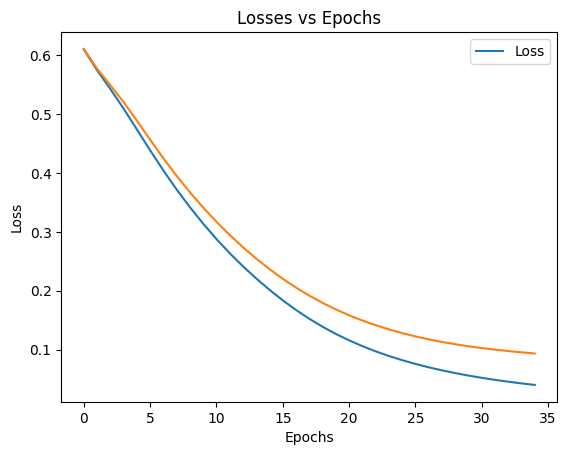

In [25]:
plt.plot(loss_values, label = 'train_loss')
plt.plot(val_loss_values, label = 'val_loss')
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

In [26]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format((100*pred/len(x_test))))

Accuracy : 99.06666564941406%
